# Regression with Quantum Computing and Neural Networks


In this notebook, we explore regression tasks using Qiskit Machine Learning integrated with PyTorch. By experimenting with hybrid models—combining Quantum Neural Networks (QNNs) and Deep Neural Networks (DNNs)—we aim to achieve robust and potentially more accurate regression results.

We use the well-known Diabetes dataset, a common benchmark in machine learning due to its straightforward yet informative structure. This dataset provides an effective foundation for demonstrating both quantum and hybrid approaches in regression.


The notebook is structured into three main sections:

- Section 1: Introduction to Regression with Qiskit Machine Learning <br>
    This section provides a brief guide to the Qiskit Machine Learning library. We implement a Quantum Neural Network Regressor using Qiskit’s built-in methods, alongside a classical Support Vector Machine (SVM) regressor as a baseline for comparison.

- Section 2: Advanced Hybrid Modeling with QNNs <br>
    Here, we delve into the EstimatorQNN module. Using this module, we construct both fully quantum regressors and hybrid quantum-classical models, illustrating the strengths of each approach.
- Section 3: Results and Analysis <br>
    In this final section, we analyze and compare the performance of the different regression models, highlighting the strengths and potential limitations of quantum and hybrid methods.

In [1]:
#Import required packages
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from qiskit_aer import Aer
from qiskit.circuit.library import ZZFeatureMap, TwoLocal, RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor
from qiskit_machine_learning.connectors import TorchConnector
from qiskit import QuantumCircuit

import time
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
import torch
from torch.optim import Adam
from matplotlib import pyplot as plt
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 111
np.random.seed(111)

## Section 1: Introduction to Regression with Qiskit Machine Learning 

Regression is a fundamental task in machine learning with applications across various fields. As quantum computing technology advances, combining classical and quantum methods holds promise for improving both accuracy and computational efficiency. With high-fidelity quantum computers on the horizon, developing quantum-ready architectures, algorithms, and techniques is essential to harness their full potential.

To assess the potential benefits of quantum regression models, we need a solid baseline. In this section, we establish that baseline by implementing a classical Support Vector Machine (SVM) regressor. We then compare it with quantum neural network regressors, allowing us to evaluate how well quantum approaches perform relative to established classical methods.


In [2]:
#Import data
data = load_diabetes()

df_features = pd.DataFrame(data.data, columns=data.feature_names)
df_target = pd.DataFrame(data.target)
df_features.head(5)

data.data = data.data[:, 0:4] # We will only use 4 features

In [3]:
train_X, test_X, train_y, test_y = train_test_split(
    data.data, data.target, train_size=0.8, shuffle=True)

scaler_features = MinMaxScaler()
X_train_scaled = scaler_features.fit_transform(train_X)
X_test_scaled = scaler_features.transform(test_X)

#We need to scale for the Quantum systems
scaler_target = MinMaxScaler(feature_range=(-1, 1)) #expectation value range
y_train_scaled = scaler_target.fit_transform(train_y[:,np.newaxis])
y_test_scaled = scaler_target.transform(test_y[:,np.newaxis])


num_features = train_X.shape[1]


##### 1.1 Regression with SVM

In [4]:
regressor_smv = SVR()
_ = regressor_smv.fit(X_train_scaled, train_y) 

train_pred = regressor_smv.predict(X_train_scaled)
test_pred = regressor_smv.predict(X_test_scaled)


metrics_svm = {'rmse_train': root_mean_squared_error(train_pred, train_y),
                    'rmse_test': root_mean_squared_error(test_pred, test_y),
                    'mape_train': mean_absolute_percentage_error(train_pred, train_y),
                    'mape_test': mean_absolute_percentage_error(test_pred, test_y),
                    }
print('Results SVM ')
print(f'RMSE train: { metrics_svm['rmse_train']:.4f}')
print(f'RMSE test: {  metrics_svm['rmse_test']:.4f}')
print(f'MAPE train: { metrics_svm['mape_train']:.4f}')
print(f'MAPE test: {  metrics_svm['mape_test']:.4f}')


Results SVM 
RMSE train: 74.4712
RMSE test: 65.2684
MAPE train: 0.4464
MAPE test: 0.3790


##### 1.2 QNN NeuralNetworkRegressor with the method defined in Qiskit

In [5]:
def create_estimator_qnn():

    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    #feature_map.decompose().draw(output="mpl", style="clifford")
    ansatz = RealAmplitudes(num_qubits=num_features)

    qc = QuantumCircuit(num_features)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    #qc.draw(output="mpl", style="clifford")
    qnn_estimator = EstimatorQNN(
            circuit=qc, 
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            input_gradients=True,
            )

    return qnn_estimator

In [6]:
qnn_estimator = create_estimator_qnn()
regressor_estimator = NeuralNetworkRegressor(neural_network=qnn_estimator)
regressor_estimator.fit(X_train_scaled, y_train_scaled)

/tmp/ipykernel_18698/3586250782.py:11: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn_estimator = EstimatorQNN(


In [7]:
train_pred_scaled = regressor_estimator.predict(X_train_scaled)
test_pred_scaled = regressor_estimator.predict(X_test_scaled)


train_pred = scaler_target.inverse_transform(train_pred_scaled)
test_pred = scaler_target.inverse_transform(test_pred_scaled)



metrics_estimator = {'rmse_train': root_mean_squared_error(train_pred, train_y),
                    'rmse_test': root_mean_squared_error(test_pred, test_y),
                    'mape_train': mean_absolute_percentage_error(train_pred, train_y),
                    'mape_test': mean_absolute_percentage_error(test_pred, test_y),
                    }
print('EstimatorQNN: ')
print(f'RMSE train: { metrics_estimator['rmse_train']:.4f}')
print(f'RMSE test: { metrics_estimator['rmse_test']:.4f}')
print(f'MAPE train: { metrics_estimator['mape_train']:.4f}')
print(f'MAPE test: { metrics_estimator['mape_test']:.4f}')



EstimatorQNN: 
RMSE train: 68.6160
RMSE test: 64.6615
MAPE train: 0.3892
MAPE test: 0.3335


## Section 2: Advanced Hybrid Modeling with QNNs

Here, we delve into the EstimatorQNN module. Using this module, we construct both fully quantum regressors and hybrid quantum-classical models, illustrating the strengths of each approach.



In [8]:
#Convert data in tensor
X_tensor_train_scaled = torch.Tensor(X_train_scaled)
y_tensor_train = torch.Tensor(train_y)[:,None]
y_tensor_train_scaled = torch.Tensor(y_train_scaled)
X_tensor_test_scaled = torch.Tensor(X_test_scaled)
y_tensor_test = torch.Tensor(test_y)[:,None]
y_tensor_test_scaled = torch.Tensor(y_test_scaled)
num_features = train_X.shape[1]

In [9]:
#Define the EstimatorQNN
def create_estimator_qnn():

    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    #feature_map.decompose().draw(output="mpl", style="clifford")
    ansatz = RealAmplitudes(num_qubits=num_features)

    qc = QuantumCircuit(num_features)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    #qc.draw(output="mpl", style="clifford")
    
    qnn_estimator = EstimatorQNN(
            circuit=qc, 
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            input_gradients=True,
            )

    return qnn_estimator


In [10]:
class QuantumRegressor(torch.nn.Module):
        def __init__(self, qnn_regressor):
            super(QuantumRegressor, self).__init__()
            self.qnn_regressor = TorchConnector(qnn_regressor)

        def forward(self, x):
              
              output  = self.qnn_regressor(x)
              return output
        
qnn_regressor = create_estimator_qnn()

model_estimator_qnn = QuantumRegressor(qnn_regressor=qnn_regressor)

total_qnn_params = (qnn_regressor.num_weights)
total_params = sum(p.numel() for p in model_estimator_qnn.parameters())

print(f"Total QNN Parameters: {total_qnn_params}")
print(f"Total Parameters: {total_params}")


Total QNN Parameters: 16
Total Parameters: 16


/tmp/ipykernel_18698/927456755.py:13: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn_estimator = EstimatorQNN(


In [11]:
loss_function = torch.nn.MSELoss()
optimizer = Adam(model_estimator_qnn.parameters(), lr=0.1)

# Training loop
num_epochs = 100
loss_train_estimator = []
metrics = {'rmse_train_estimator':[],
           'rmse_test_estimator':[]}
for epoch in range(num_epochs):
    model_estimator_qnn.train()
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model_estimator_qnn(X_tensor_train_scaled)
    loss = loss_function(outputs, y_tensor_train_scaled)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    loss_train_estimator.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

    model_estimator_qnn.eval()
    train_pred_scaled = (model_estimator_qnn(X_tensor_train_scaled)).detach().numpy()
    train_pred = scaler_target.inverse_transform(train_pred_scaled)
    
    metrics['rmse_train_estimator'].append(root_mean_squared_error(train_pred, train_y))

    test_pred_scaled = (model_estimator_qnn(X_tensor_test_scaled)).detach().numpy()
    test_pred = scaler_target.inverse_transform(test_pred_scaled)
    metrics['rmse_test_estimator'].append(root_mean_squared_error(test_pred, test_y))

Epoch 0: Loss = 0.33182984590530396
Epoch 10: Loss = 0.22916671633720398
Epoch 20: Loss = 0.2078421413898468
Epoch 30: Loss = 0.19519783556461334
Epoch 40: Loss = 0.19315752387046814
Epoch 50: Loss = 0.19077333807945251
Epoch 60: Loss = 0.19066138565540314
Epoch 70: Loss = 0.19050128757953644
Epoch 80: Loss = 0.1903109848499298
Epoch 90: Loss = 0.19017639756202698


In [12]:
#Evaluate the model
model_estimator_qnn.eval()

train_pred_scaled = (model_estimator_qnn(X_tensor_train_scaled)).detach().numpy()
test_pred_scaled = (model_estimator_qnn(X_tensor_test_scaled)).detach().numpy()

train_pred = scaler_target.inverse_transform(train_pred_scaled)
test_pred = scaler_target.inverse_transform(test_pred_scaled)


metrics_estimator = {'rmse_train': root_mean_squared_error(train_pred, train_y),
                     'rmse_test': root_mean_squared_error(test_pred, test_y),
                     'mape_train': mean_absolute_percentage_error(train_pred, train_y),
                     'mape_test': mean_absolute_percentage_error(test_pred, test_y),
                    }

print('Estimator QNN: ')
print(f'RMSE train: { metrics_estimator['rmse_train']:.4f}')
print(f'RMSE test: { metrics_estimator['rmse_test']:.4f}')
print(f'MAPE train: { metrics_estimator['mape_train']:.4f}')
print(f'MAPE test: { metrics_estimator['mape_test']:.4f}')

Estimator QNN: 
RMSE train: 69.9893
RMSE test: 65.6515
MAPE train: 0.4001
MAPE test: 0.3550


#### 2.2  EstimatorQNN + Classical Neural Network

Note that here we have created a system in which we consider classical layers, then the QNN, and finally another classical layer.

In [13]:

class QuantumRegressor_Multilayer(torch.nn.Module):
        def __init__(self, qnn_regressor, num_features):
            super(QuantumRegressor_Multilayer, self).__init__()

            self.pre_qnn_layer_1 = torch.nn.Linear(in_features=num_features, out_features=10)
            self.pre_qnn_layer_2 = torch.nn.Linear(in_features=10, out_features=num_features)            
            self.qnn_regressor = TorchConnector(qnn_regressor)
            self.post_qnn_layer = torch.nn.Linear(in_features=1, out_features=1)

        def forward(self, x):
              
              x = torch.nn.functional.relu(self.pre_qnn_layer_1(x))
              x = torch.nn.functional.relu(self.pre_qnn_layer_2(x))

              x  = self.qnn_regressor(x)
              output = self.post_qnn_layer(x)

              return output
        
qnn_regressor = create_estimator_qnn()

model_estimator_hybrid = QuantumRegressor_Multilayer(qnn_regressor=qnn_regressor,num_features=num_features)

total_qnn_params = (qnn_regressor.num_weights)
total_params = sum(p.numel() for p in model_estimator_hybrid.parameters())

print(f"Total QNN Parameters: {total_qnn_params}")
print(f"Total Parameters: {total_params}")


Total QNN Parameters: 16
Total Parameters: 112


/tmp/ipykernel_18698/927456755.py:13: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn_estimator = EstimatorQNN(


In [14]:
loss_function = torch.nn.MSELoss()
optimizer = Adam(model_estimator_hybrid.parameters(), lr=0.1)


# Training loop
num_epochs = 100
loss_estimator_hybrid = []
metrics['rmse_train_estimator_hybrid'], metrics['rmse_test_estimator_hybrid'] = [], []
for epoch in range(num_epochs):
    model_estimator_hybrid.train()
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model_estimator_hybrid(X_tensor_train_scaled)
    loss = loss_function(outputs, y_tensor_train_scaled)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    loss_estimator_hybrid.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

    model_estimator_hybrid.eval()
    train_pred_scaled = (model_estimator_hybrid(X_tensor_train_scaled)).detach().numpy()
    train_pred = scaler_target.inverse_transform(train_pred_scaled)
    
    metrics['rmse_train_estimator_hybrid'].append(root_mean_squared_error(train_pred, train_y))

    test_pred_scaled = (model_estimator_hybrid(X_tensor_test_scaled)).detach().numpy()
    test_pred = scaler_target.inverse_transform(test_pred_scaled)
    metrics['rmse_test_estimator_hybrid'].append(root_mean_squared_error(test_pred, test_y))

Epoch 0: Loss = 1.1099830865859985
Epoch 10: Loss = 0.2585356533527374
Epoch 20: Loss = 0.25809356570243835
Epoch 30: Loss = 0.23403796553611755
Epoch 40: Loss = 0.21179603040218353
Epoch 50: Loss = 0.20605170726776123
Epoch 60: Loss = 0.19324205815792084
Epoch 70: Loss = 0.17334510385990143
Epoch 80: Loss = 0.1606459617614746
Epoch 90: Loss = 0.15025319159030914


In [15]:
#Evaluate the model
model_estimator_hybrid.eval()

train_pred_scaled = (model_estimator_hybrid(X_tensor_train_scaled)).detach().numpy()
test_pred_scaled = (model_estimator_hybrid(X_tensor_test_scaled)).detach().numpy()

train_pred = scaler_target.inverse_transform(train_pred_scaled)
test_pred = scaler_target.inverse_transform(test_pred_scaled)


metrics_estimator_hybrid = {'rmse_train': root_mean_squared_error(train_pred, train_y),
                     'rmse_test': root_mean_squared_error(test_pred, test_y),
                     'mape_train': mean_absolute_percentage_error(train_pred, train_y),
                     'mape_test': mean_absolute_percentage_error(test_pred, test_y),
                    }

print('EstimatorQNN Hybrid: ')
print(f'RMSE train: { metrics_estimator_hybrid['rmse_train']:.4f}')
print(f'RMSE test: { metrics_estimator_hybrid['rmse_test']:.4f}')
print(f'MAPE train: { metrics_estimator_hybrid['mape_train']:.4f}')
print(f'MAPE test: { metrics_estimator_hybrid['mape_test']:.4f}')

EstimatorQNN Hybrid: 
RMSE train: 60.6897
RMSE test: 60.5922
MAPE train: 0.3505
MAPE test: 0.3448


## Section 3: Results and Analysis
In this section, we evaluate the performance of the different models used in our regression task.

Both the purely quantum model and the hybrid quantum-classical model delivered impressive results, with the hybrid quantum-classical model outperforming the baseline SVM on the train and test set. While these findings are encouraging, it's important to note that they may not generalize across all regression problems. Throughout this tutorial, we illustrate that both quantum and hybrid systems can achieve significant outcomes.

Additionally, examining the learning curves reveals that the purely quantum model shows signs of overfitting, as evident in the figure below. To address this, strategies such as early stopping, regularization, or data augmentation could be applied to improve model generalization.




In [16]:

print(f'RMSE SVM train: { metrics_svm['rmse_train']:.4f}')
print(f'RMSE estimator QNN train: { metrics_estimator['rmse_train']:.4f}')
print(f'RMSE estimator hybrid train: { metrics_estimator_hybrid['rmse_train']:.4f}')
print('------------------------------')
print(f'RMSE SVM test: { metrics_svm['rmse_test']:.4f}')
print(f'RMSE estimator QNN test: { metrics_estimator['rmse_test']:.4f}')
print(f'RMSE estimator hybrid test: { metrics_estimator_hybrid['rmse_test']:.4f}')


RMSE SVM train: 74.4712
RMSE estimator QNN train: 69.9893
RMSE estimator hybrid train: 60.6897
------------------------------
RMSE SVM test: 65.2684
RMSE estimator QNN test: 65.6515
RMSE estimator hybrid test: 60.5922


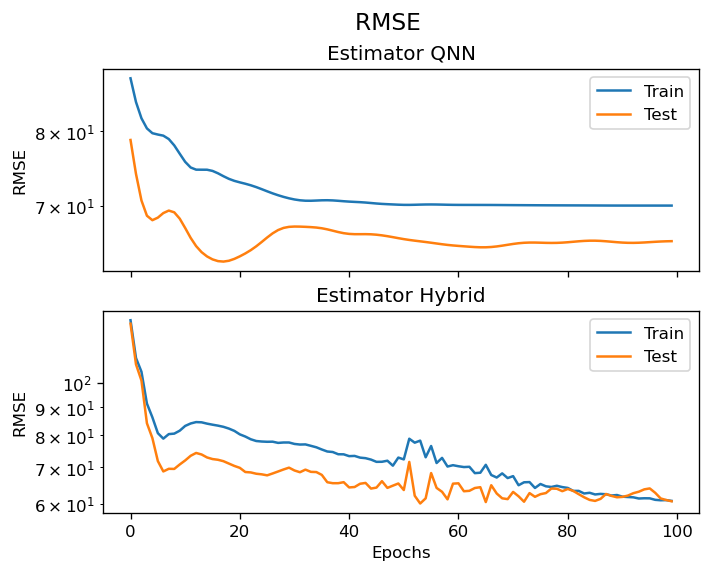

In [17]:
metricfig, ax = plt.subplots(2, sharex=True, dpi =120)
ax[0].plot(np.arange(len(metrics['rmse_train_estimator'])), metrics['rmse_train_estimator'], label='Train')
ax[0].plot(np.arange(len(metrics['rmse_test_estimator'])), metrics['rmse_test_estimator'], label='Test')
ax[0].legend(loc=1)
ax[0].set_ylabel('RMSE')
ax[0].set_title('Estimator QNN')
ax[0].set_yscale('log')


ax[1].plot(np.arange(len(metrics['rmse_train_estimator_hybrid'])), metrics['rmse_train_estimator_hybrid'], label='Train')
ax[1].plot(np.arange(len(metrics['rmse_test_estimator_hybrid'])), metrics['rmse_test_estimator_hybrid'], label='Test')
ax[1].legend(loc=1)
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Estimator Hybrid')
ax[1].set_yscale('log')
plt.suptitle('RMSE ', fontsize=14)
plt.show()

## Future Work

Future efforts could focus on hyperparameter tuning to optimise model performance. This includes adjusting the number of neurons, selecting the best ansatz and feature maps, and exploring other parameter settings. In addition, an in-depth analysis of computational costs and run-time performance would provide insight into the practical advantages of quantum regressor compared to classical models, which would help clarify any genuine advantages of quantum systems for regression tasks.